![](http://wiki.swarma.net/images/e/e7/集智AI学园首页左上角logo_2017.8.17.png)

# 火炬上的深度学习（下）第三节：神经网络莫扎特

## 课后作业：使用 LSTM 编写一个国际姓氏生成模型

在火炬课程中，我们学习了使用 LSTM 来生成 MIDI 音乐。这节课我们使用类似的方法，再创建一个 LSTM 国际起名大师！

完成后的模型能够像下面这样使用，指定一个国家名，模型即生成几个属于这个国家的姓氏。

```
> python generate.py Russian
Rovakov    Uantov    Shavakov

> python generate.py German
Gerren    Ereng    Rosher

> python generate.py Spanish
Salla    Parer    Allan

> python generate.py Chinese
Chan    Hang    Iun
```

In [5]:
# 第一步当然是引入PyTorch及相关包
import torch
import torch.nn as nn
import torch.optim
from torch.autograd import Variable
import numpy as np

## 准备数据


这次的数据仍然是18个文本文件，每个文件以“国家名字”命名，文件中存储了大量这个国家的姓氏。

在读取这些数据前，为了简化神经网络的输入参数规模，我们把各国各语言人名都转化成用26个英文字母来表示，下面就是转换的方法。

In [6]:
import glob
import unicodedata
import string

# all_letters 即课支持打印的字符+标点符号
all_letters = string.ascii_letters + " .,;'-"
# Plus EOS marker
n_letters = len(all_letters) + 1 
EOS = n_letters - 1

def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_to_ascii("O'Néàl"))

O'Neal


可以看到 `"O'Néàl"` 被转化成了以普通ASCII字符表示的 `O'Neal`。

在上面的代码中，还要注意这么几个变量。

In [7]:
# 姓氏中所有的可视字符
print('all_letters: ', all_letters)
# 所有字符的长度 +1 EOS结束符
print('n_letters: ', n_letters)
# 结束符，没有实质内容
print('EOS: ', EOS)

all_letters:  abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'-
n_letters:  59
EOS:  58


其中 `all_letters` 包含了我们数据集中所有可能出现的字符，也就是“字符表”。
`n_letters` 是字符表的长度，在本例中长度为59。`EOS` 的索引号为58，它在字符表中没有对应的字符，仅代表结束。

## 读取数据

准备好处理数据的方法，下面就可以放心的读取数据了。

我们建立一个列表 `all_categories` 用于存储所有的国家名字。

建立一个字典 `category_lines`，以读取的国名作为字典的索引，国名下存储对应国别的名字。

In [8]:
# 按行读取出文件中的名字，并返回包含所有名字的列表
def read_lines(filename):
    lines = open(filename).read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]


# category_lines是一个字典
# 其中索引是国家名字，内容是从文件读取出的这个国家的所有名字
category_lines = {}
# all_categories是一个列表
# 其中包含了所有的国家名字
all_categories = []
# 循环所有文件
for filename in glob.glob('.\\names\\*.txt'):
    # 从文件名中切割出国家名字
    category = filename.split('\\')[-1].split('.')[0]
    # 将国家名字添加到列表中
    all_categories.append(category)
    # 读取对应国别文件中所有的名字
    lines = read_lines(filename)
    # 将所有名字存储在字典中对应的国别下
    category_lines[category] = lines

# 共有的国别数
n_categories = len(all_categories)

print('# categories: ', n_categories, all_categories)
print()
print('# Russian names: ', category_lines['Russian'][:10])

# categories:  18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']

# Russian names:  ['Ababko', 'Abaev', 'Abagyan', 'Abaidulin', 'Abaidullin', 'Abaimoff', 'Abaimov', 'Abakeliya', 'Abakovsky', 'Abakshin']


In [9]:
# 再统计下手头共有多少条训练数据
all_line_num = 0
for key in category_lines:
    all_line_num += len(category_lines[key])
print(all_line_num)

20074


现在我们的数据准备好了，可以搭建神经网络了！

## 准备训练

首先建立一个可以随机选择数据对 `(category, line)` 的方法，以方便训练时调用。

In [10]:
import random

def random_training_pair():
    # 随机选择一个国别名
    category = random.choice(all_categories)
    # 读取这个国别名下的所有人名
    line = random.choice(category_lines[category])
    return category, line

print(random_training_pair())

('Spanish', 'Abascal')


首先处理国别，将国别名转化为索引。

这个索引是要和姓氏一起传入神经网络模型的。我们这次编写的是根据“国名条件”生成“符合条件的姓氏”的 LSTM 模型。这种将“条件”和“符合条件的数据”合并一起作为训练输入数据的方法，在“条件模型”里非常流行。

比如 条件GAN（Conditional GAN），在训练时是把数据标签拼接到数据图片中一起进行训练的。

In [11]:
# 将名字所属的国家名转化为“独热向量”
def make_category_input(category):
    li = all_categories.index(category)
    return  li

print(make_category_input('Italian'))

9



对于训练过程中的每一步，或者说对于训练数据中每个名字的每个字符来说，神经网络的输入是 `(category, current letter, hidden state)`，输出是 `(next letter, next hidden state)`。

与在课程中讲的一样，神经网络还是依据“当前的字符”预测“下一个字符”。比如对于“Kasparov”这个名字，创建的（input, target）数据对是 ("K", "a"), ("a", "s"), ("s", "p"), ("p", "a"), ("a", "r"), ("r", "o"), ("o", "v"), ("v", "EOS")。


In [12]:
def make_chars_input(nameStr):
    name_char_list = list(map(lambda x: all_letters.find(x), nameStr))
    return name_char_list


def make_target(nameStr):
    target_char_list = list(map(lambda x: all_letters.find(x), nameStr[1:]))
    target_char_list.append(n_letters - 1)# EOS
    return target_char_list

同样为了训练时方便使用，我们建立一个 `random_training_set` 函数，以随机选择出数据集 `(category, line)` 并转化成训练需要的 Tensor： `(category, input, target) `。

In [13]:
def random_training_set():
    # 随机选择数据集
    category, line = random_training_pair()
    #print(category, line)
    # 转化成对应 Tensor
    category_input = make_category_input(category)
    line_input = make_chars_input(line)
    #category_name_input = make_category_name_input(category, line)
    line_target = make_target(line)
    return category_input, line_input, line_target
    #return category_name_input, line_target

In [14]:
print(random_training_set())

(5, [33, 4, 17, 1, 4, 17, 19], [4, 17, 1, 4, 17, 19, 58])


# 搭建神经网络

这次使用的 LSTM 神经网络整体结构上与课上讲的生成音乐的模型非常相似，不过有一点请注意一下。

我们要把国别和国别对应的姓氏一同输入到神经网络中，这样 LSTM 模型才能分别学习到每个国家姓氏的特色，从而生成不同国家不同特色的姓氏。

那国别数据与姓氏数据应该如何拼接哪？应该在嵌入前拼接，还是在嵌入后再进行拼接哪？嵌入后的维度与 hidden_size 有怎样的关系哪？


** 你需要参考课上的模型，将这个模型补充完整。**

In [85]:
# 一个手动实现的LSTM模型，

class LSTMNetwork(nn.Module):
    def __init__(self, category_size, name_size, hidden_size, output_size, num_layers = 1):
        super(LSTMNetwork, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        
        self.i2h = nn.Linear(category_size + name_size,hidden_size)
      
        # 隐含层内部的相互链接
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first = True)
        
        # 输出层
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax()

    def forward(self, category_variable, name_variable, hidden):
        
        # 先分别进行embedding层的计算
 
        # 从输入到隐含层的计算
        x = self.i2h(torch.cat((category_variable,name_variable),2))
        
        # output的尺寸：batch_size, len_seq, hidden_size
        output, hidden = self.lstm(x, hidden)
        output = output[:,-1,:]

        # 全连接层
        output = self.fc(output)

        # output的尺寸：batch_size, output_size
        # softmax函数
        output = self.softmax(output)

        return output, hidden
 
    def initHidden(self):
        # 对隐含单元的初始化
        # 注意尺寸是： layer_size, batch_size, hidden_size
        # 对隐单元的初始化
        # 对引单元输出的初始化，全0.
        # 注意hidden和cell的维度都是layers,batch_size,hidden_size
        hidden = Variable(torch.zeros(self.num_layers, 1, self.hidden_size))
        # 对隐单元内部的状态cell的初始化，全0
        cell = Variable(torch.zeros(self.num_layers, 1, self.hidden_size))
        return (hidden, cell)

## 开始训练！

与之前处理得分类问题不同，在分类问题中只有最后的输出被使用。而在当前的 **生成** 姓氏的任务中，神经网络在每一步都会做预测，所以我们需要在每一步计算损失值。

PyTorch 非常易用，它允许我们只是简单的把每一步计算的损失加起来，在遍历完一个姓氏后，再进行反向传播。

** 你需要将训练函数补充完整，或者编写自己的训练函数。**

In [90]:
# 定义训练函数，在这个函数里，我们可以随机选择一条训练数据，遍历每个字符进行训练
def train_LSTM():
    # 初始化 隐藏层、梯度清零、损失清零
    hidden = lstm.initHidden()
    loss = 0
    optimizer.zero_grad()
    # 随机选取一条训练数据
    category_input, line_input, line_target = random_training_set()
    # 处理国别数据
    category_tensor = torch.zeros(1,1,n_categories)
    category_tensor[0][0][category_input] = 1
    category_variable = Variable(category_tensor)
    # 循环字符
    for t in range(len(line_input)):
        # 姓氏
        letter = line_input[t]
        name_tensor = torch.zeros(1,1,n_letters)
        name_tensor[0][0][letter] = 1
        name_variable = Variable(name_tensor)
        # 目标
        y = Variable(torch.LongTensor([line_target[t]]))
        # 传入模型
        output, hidden = lstm(category_variable,name_variable, hidden)
        # 累加损失
        loss += criterion(output, y)
    
    # 计算平均损失
    loss = 1.0 * loss / len(line_input)
    loss.backward(retain_variables = True)
    optimizer.step()
    # train_loss += loss
    # 反向传播、更新梯度
    
    
    return loss

我们定义 `time_since` 函数，它可以打印出训练持续的时间。

In [87]:
import time
import math

def time_since(t):
    now = time.time()
    s = now - t
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

**在下面你要定义损失函数、优化函数、实例化模型参数。**

In [88]:
HIDDEN_SIZE = 10
num_epoch = 3
learning_rate = 0.001

# 实例化模型
lstm = LSTMNetwork(category_size = n_categories, name_size = n_letters, hidden_size = HIDDEN_SIZE, output_size = n_letters, num_layers = 1)
# 定义损失函数与优化方法
optimizer = torch.optim.Adam(lstm.parameters(), lr = 0.001)
criterion = torch.nn.NLLLoss()

训练的过程与我们前几节课一样，都是老套路啦！


In [84]:
a = torch.zeros(1,1,n_letters)
b = torch.zeros(1,1,n_categories)
b
# b = torch.zeros(5)
# a[1] = 1
# a
c = torch.cat((a,b),2)
# c
nn.Linear(n_letters+n_categories,1)(Variable(c))


Variable containing:
(0 ,.,.) = 
1.00000e-02 *
  -4.9922
[torch.FloatTensor of size 1x1x1]

In [91]:
start = time.time()

records = []
# 开始训练循环
for epoch in range(num_epoch):
    train_loss = 0
    # 按所有数据的行数随机循环
    for i in range(all_line_num):
        loss = train_LSTM()
        train_loss += loss
        
        #每隔3000步，跑一次校验集，并打印结果
        if i % 3000 == 0:
            training_process = (all_line_num * epoch + i) / (all_line_num * num_epoch) * 100
            training_process = '%.2f' % training_process
            print('第{}轮，训练损失：{:.2f}，训练进度：{}%，（{}）'\
                .format(epoch, train_loss.data.numpy()[0] / i, float(training_process), time_since(start)))
            records.append([train_loss.data.numpy()[0] / i])

C:\Users\wwz\Anaconda3\envs\deeplearning\lib\site-packages\torch\autograd\__init__.py:92: UserWarning: retain_variables option is deprecated and will be removed in 0.3. Use retain_graph instead.
  warnings.warn("retain_variables option is deprecated and will be removed in 0.3. "
C:\Users\wwz\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
C:\Users\wwz\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


第0轮，训练损失：inf，训练进度：0.0%，（0m 2s）
第0轮，训练损失：2.79，训练进度：4.98%，（1m 4s）
第0轮，训练损失：2.66，训练进度：9.96%，（2m 2s）
第0轮，训练损失：2.58，训练进度：14.94%，（2m 51s）
第0轮，训练损失：2.53，训练进度：19.93%，（3m 40s）
第0轮，训练损失：2.49，训练进度：24.91%，（4m 26s）
第0轮，训练损失：2.46，训练进度：29.89%，（5m 14s）
第1轮，训练损失：inf，训练进度：33.33%，（6m 11s）
第1轮，训练损失：2.26，训练进度：38.31%，（7m 6s）
第1轮，训练损失：2.24，训练进度：43.3%，（8m 4s）
第1轮，训练损失：2.23，训练进度：48.28%，（8m 57s）
第1轮，训练损失：2.22，训练进度：53.26%，（9m 42s）
第1轮，训练损失：2.22，训练进度：58.24%，（10m 28s）
第1轮，训练损失：2.21，训练进度：63.22%，（11m 16s）
第2轮，训练损失：inf，训练进度：66.67%，（12m 0s）
第2轮，训练损失：2.17，训练进度：71.65%，（12m 51s）
第2轮，训练损失：2.16，训练进度：76.63%，（13m 48s）
第2轮，训练损失：2.15，训练进度：81.61%，（14m 45s）
第2轮，训练损失：2.15，训练进度：86.59%，（15m 40s）
第2轮，训练损失：2.15，训练进度：91.57%，（16m 25s）
第2轮，训练损失：2.14，训练进度：96.56%，（17m 11s）


## 绘制观察损失曲线

让我们将训练过程中记录的损失绘制成一条曲线，观察下神经网络学习的效果。

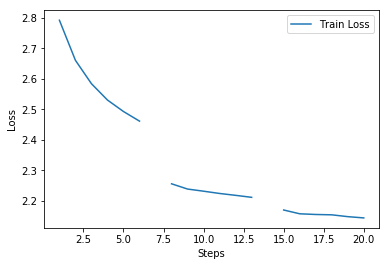

In [92]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

a = [i[0] for i in records]
plt.plot(a, label = 'Train Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

因为我在计算损失平均值时有“除0错误”，所以在损失曲线中有间断，大家可以改进我的计算方法，让损失曲线连贯起来。

## 测试使用神经网络

既然神经网络训练好了，那也就是说，我们喂给它第一个字符，他就能生成第二个字符，喂给它第二个字符，它就会生成第三个，这样一直持续下去，直至生成 EOS 才结束。

那下面我们编写 `generate_one` 函数以方便的使用神经网络生成我们想要的名字字符串，在这个函数里我们定义以下内容：

* 建立输入国别，开始字符，初始隐藏层状态的 Tensor
* 创建 `output_str` 变量，创建时其中只包含“开始字符”
* 定义生成名字的长度最大不超过 `max_length`
    * 将当前字符传入神经网络
    * 在输出中选出预测的概率最大的下一个字符，同时取出当前的隐藏层状态
    * 如果字符是 EOS，则生成结束
    * 如果是常规字符，则加入到 `output_str` 中并继续下一个流程
* 返回最终生成的名字字符串

** 你需要自行编写模型验证方法。 **

In [98]:
max_length = 20

# 通过指定国别名 category
# 以及开始字符 start_char
# 还有混乱度 temperature 来生成一个名字
def generate_one(category, start_char='A', temperature=0.2):
    # 初始化输入数据，国别 以及 输入的第一个字符
    # 国别
    category_input = make_category_input(category)
    category_tensor = torch.zeros(1,1,n_categories)
    category_tensor[0][0][category_input] = 1
    category_variable = Variable(category_tensor)
    # 第一个字符
    letter = make_chars_input(start_char)[0]
    name_tensor = torch.zeros(1,1,n_letters)
    name_tensor[0][0][letter] = 1
    name_variable = Variable(name_tensor)
    # 初始化隐藏层
    hidden = lstm.initHidden()

    output_str = start_char
    
    for i in range(max_length):
        
        # 调用模型
        output, hidden = lstm(category_variable,name_variable,hidden)
        
        # 这里是将输出转化为一个多项式分布
        output_dist = output.data.view(-1).div(temperature).exp()
        # 从而可以根据混乱度 temperature 来选择下一个字符
        # 混乱度低，则趋向于选择网络预测最大概率的那个字符
        # 混乱度高，则趋向于随机选择字符
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # 生成字符是 EOS，则生成结束
        if top_i == EOS:
            break
        else:
            # 继续下一个字符
            char = all_letters[top_i]
            output_str += char
            letter = make_chars_input(char)[0]
            name_tensor = torch.zeros(1,1,n_letters)
            name_tensor[0][0][letter] = 1
            name_variable = Variable(name_tensor)
            #name_variable = Variable(torch.LongTensor([chars_input]))
            
    return output_str

# 再定义一个函数，方便每次生成多个名字
def generate(category, start_chars='ABC'):
    for start_char in start_chars:
        print(generate_one(category, start_char))

In [97]:
make_chars_input("A")[0]

26

In [99]:
generate('Russian', 'RUS')

Raska
Undan
Sanin


In [100]:
generate('German', 'GER')

Gorn
Erder
Rand


In [36]:
generate('Spanish', 'SPA')

Saro
Pares
Astes


In [37]:
generate('Chinese', 'CHI')

Chan
Han
Ing


可以看到 LSTM 预测的效果，但显然还不理想，我想你可以通过调整网络模型，或者通过调整超参数让模型表现的更好。

![](http://wiki.swarma.net/images/c/ca/AI学园.jpg)